In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
مدلسازی و حل مسئله
</div>

In [8]:
# ---------------------------------------------------------------------------- #
#                              Import the modules                              #
# ---------------------------------------------------------------------------- #
import pandas as pd
import gurobipy as gb

# ---------------------------------------------------------------------------- #
#                             Initialize the MODEL                             #
# ---------------------------------------------------------------------------- #
model = gb.Model(name="Machine Product")

machines = [1, 2, 3, 4, 5]
products = [1, 2, 3]
products_dict = {1:"A",2:"B",3:"C"}

# ---------------------------------------------------------------------------- #
#                             Define the VARIABLES                             #
# ---------------------------------------------------------------------------- #

X = model.addVars(((i, j) for i in machines for j in products) , vtype=gb.GRB.INTEGER, name='X') 
Y = model.addVars(((i, j) for i in machines for j in products), vtype=gb.GRB.CONTINUOUS, name="Y")
P = model.addVar(vtype=gb.GRB.BINARY, name="P")
F1 = model.addVar(vtype=gb.GRB.BINARY, name="F1")
F2 = model.addVar(vtype=gb.GRB.BINARY, name="F2")
F3 = model.addVar(vtype=gb.GRB.BINARY, name="F3")
G = model.addVar(vtype=gb.GRB.BINARY, name="G")
K = model.addVar(vtype=gb.GRB.BINARY, name="K")
Q = model.addVar(vtype=gb.GRB.BINARY, name="Q")

L = model.addVar(vtype=gb.GRB.INTEGER, name="L")

# ---------------------------------------------------------------------------- #
#                         Define the OBJECTIVE FUNCTION                        #
# ---------------------------------------------------------------------------- #
model.setObjective(L, gb.GRB.MINIMIZE)
model.setParam('OutputFlag', 0)

# ---------------------------------------------------------------------------- #
#                               Define the PARAMS                              #
# ---------------------------------------------------------------------------- #

# --------------- Work time for each product with each machine --------------- #
times = pd.read_excel('Time Data.xlsx', index_col=0)

keys = list(times.to_dict().keys())
values = list(times.to_dict().values())

time_params = {(j+1,i):k for i in range(1,len(keys)+1) for j,k in enumerate(values[i-1].values())}

# ----------------------------------- Big M ---------------------------------- #
M = 1000


# -------------------------- Machines cool down time ------------------------- #
machines_cool_down_times = {1:4, 2:10, 3:5, 4:20, 5:0}

# ---------------------------------------------------------------------------- #
#                            Define the CONSTRAINTS                            #
# ---------------------------------------------------------------------------- #

# -------------------- Linearazation of objective function ------------------- #
model.addConstr(L >= Y[4, 1])
model.addConstr(L >= Y[5, 2])
model.addConstr(L >= Y[5, 3])

# ---------------------------------- X and Y --------------------------------- #
for machine in machines:
    for product in products:
        model.addConstr(Y[machine, product] >= X[machine, product])
        model.addConstr(X[machine, product] + time_params[machine, product] == Y[machine, product])

# ----------- Each product must pass through machines sequentially ----------- #
for j in products:
    for i in range(1,len(machines)):
        model.addConstr(Y[i, j] <= X[i+1, j])
model.addConstr(Y[5, 2] <= Y[5, 3] + 15)

# ------------------------------- A finish time ------------------------------ #
model.addConstr(Y[4, 1] <= 60)

# --------------------- Machines can do one thing at once -------------------- #

# Machine 1
model.addConstr(X[1, 1] - Y[1, 2] >= machines_cool_down_times[1] - M*P)
model.addConstr(X[1, 2] - Y[1, 1] >= machines_cool_down_times[1] - M*(1 - P))

# Machine 2
model.addConstr(X[2, 2] - Y[2, 1] >= machines_cool_down_times[2] - M*F1)
model.addConstr(X[2, 1] - Y[2, 2] >= machines_cool_down_times[2] - M*(1 - F1))
model.addConstr(X[2, 3] - Y[2, 1] >= machines_cool_down_times[2] - M*F2)
model.addConstr(X[2, 1] - Y[2, 3] >= machines_cool_down_times[2] - M*(1 - F2))
model.addConstr(X[2, 2] - Y[2, 3] >= machines_cool_down_times[2] - M*F3)
model.addConstr(X[2, 3] - Y[2, 2] >= machines_cool_down_times[2] - M*(1 - F3))

# Machine 3
model.addConstr(X[3, 3] - Y[3, 1] >= machines_cool_down_times[3] - M*G)
model.addConstr(X[3, 1] - Y[3, 3] >= machines_cool_down_times[3] - M*(1 - G))

# Machine 4
model.addConstr(X[4, 1] - Y[4, 2] >= machines_cool_down_times[4] - M*K)
model.addConstr(X[4, 2] - Y[4, 1] >= machines_cool_down_times[4] - M*(1 - K))

# Machine 5
model.addConstr(X[5, 2] - Y[5, 3] >= machines_cool_down_times[5] - M*Q)
model.addConstr(X[5, 3] - Y[5, 2] >= machines_cool_down_times[5] - M*(1 - Q))

# ---------------------------------------------------------------------------- #
#                              Binary constraints                              #
# ---------------------------------------------------------------------------- #
model.addConstr(F2 + F3 - F1 >= 0)
model.addConstr(F2 + F3 - F1 <= 1)

# ---------------------------------------------------------------------------- #
#                                Solve the model                               #
# ---------------------------------------------------------------------------- #

model.update()
model.optimize() 

result = {}

for i in model.getVars():
    result[i.VarName] = (i.X)
Z = model.getVarByName("L")
print("Optimal Solution: " + str(Z.X))

Optimal Solution: 96.0


<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
مقدار تابع هدف: 96
</div>

<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
رسم گانت چارت
</div>

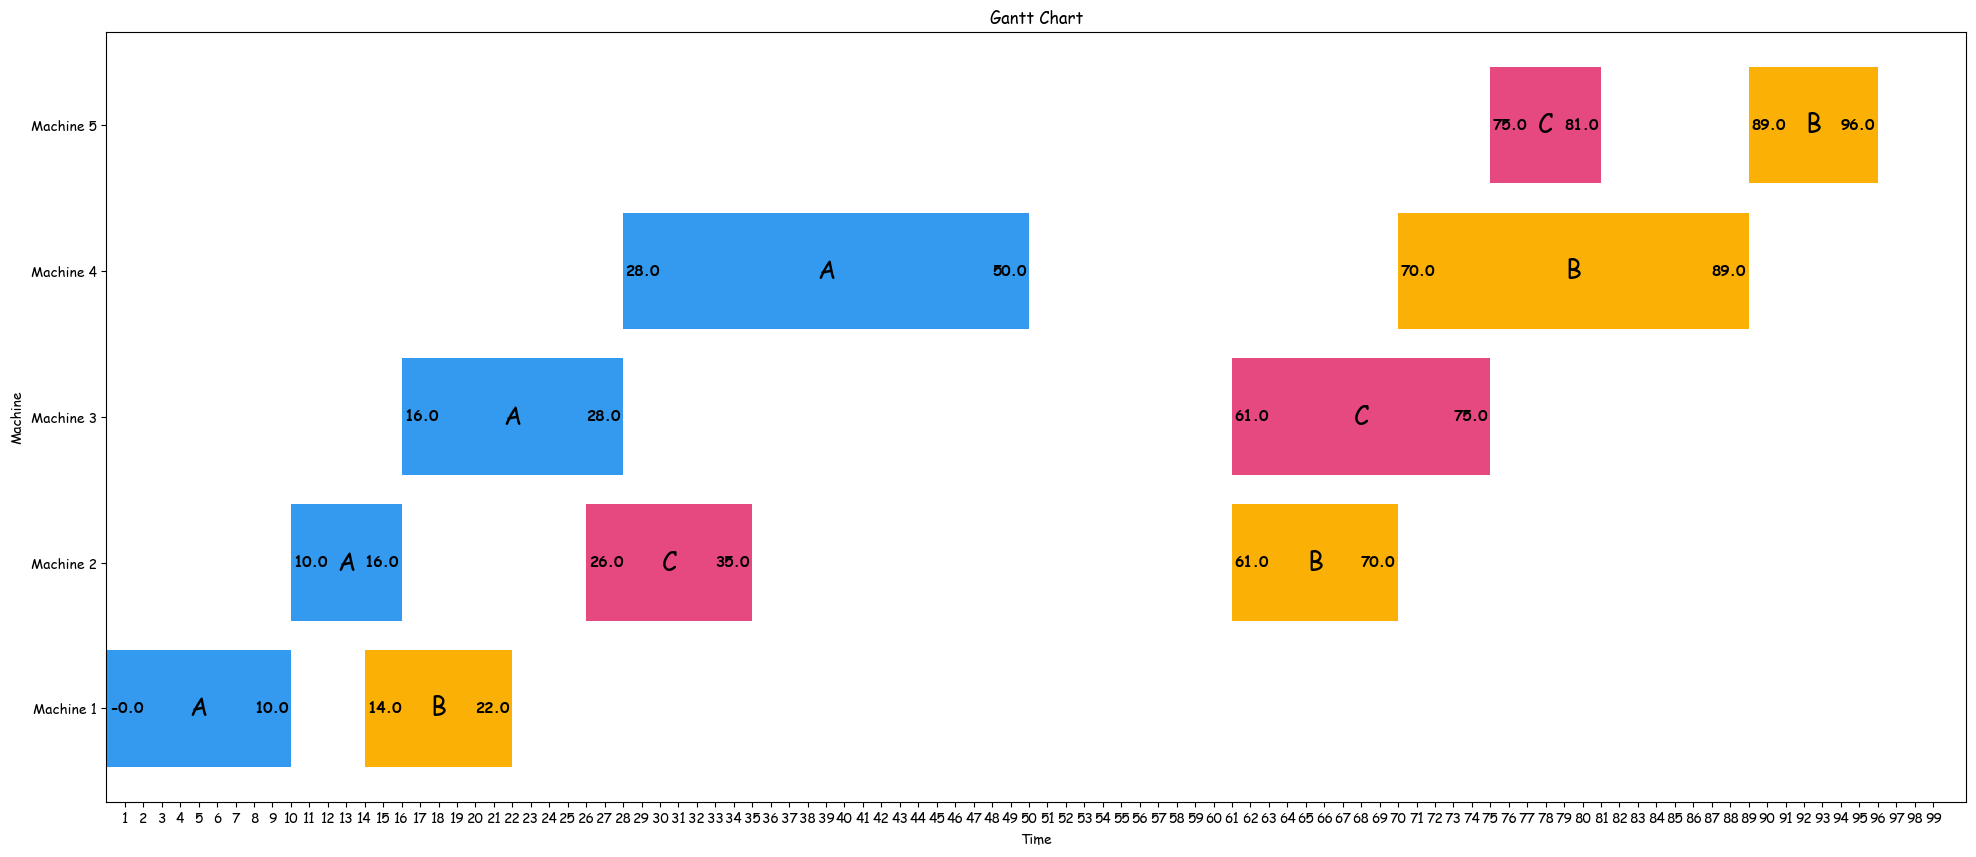

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
fig, ax = plt.subplots(figsize=(24, 10))

products_dict = {1: "A", 2: "B", 3: "C"}
products_color = {1: "#339af0", 2: "#fab005", 3: "#e64980"}

for x in machines:
    for y in products:
        start = (model.getVarByName(f'X[{x},{y}]')).X
        end = (model.getVarByName(f'Y[{x},{y}]')).X
        ax.barh(f'Machine {x}', width=end - start,
                left=start, color=products_color[y])
        if (start != end):
            ax.text(start + (end - start) / 2, x-1,
                    f'{products_dict[y]}', va='center', ha='center', fontsize=18)
            ax.text(start+2, x-1, f"{start}", ha='right',
                    va='center', fontweight=700, fontsize=11)
            ax.text(end-2, x-1, f"{end}", ha='left',
                    va='center', fontweight=700, fontsize=11)

ax.set_xlabel('Time')
ax.set_ylabel('Machine')
ax.set_title('Gantt Chart')

ax.xaxis.set_ticks(np.arange(1, 100, 1))

matplotlib.rcParams['font.family'] = ["Comic Sans MS"]

plt.show()

<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
ذخیره جواب در دیتافریم
</div>

In [10]:
tuples = [(i, j) for i in machines for j in products]
index = pd.MultiIndex.from_tuples(tuples=tuples, name=["machine", "product"])

start_times = [int(X[x,y].X) for x in machines for y in products]
end_times = [int(Y[x,y].X) for x in machines for y in products]

df = pd.DataFrame([[x,y] for x,y in zip(start_times, end_times)]  , index=index, columns=["Start Time", "End Time"])
df


Start Time  End Time
machine product                      
1       1                 0        10
        2                14        22
        3                 0         0
2       1                10        16
        2                61        70
        3                26        35
3       1                16        28
        2                70        70
        3                61        75
4       1                28        50
        2                70        89
        3                75        75
5       1                50        50
        2                89        96
        3                75        81

<div style="font-family: Vazirmatn; font-size:30px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #d6336c; padding: 20px 40px;border: 1px solid black; border-radius: 5px">
تحلیل حساسیت
</div>

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
زمان لازم برای ماشین کاری روی محصول B توسط ماشین 2
</div>

In [11]:
from utils.plot_lists import plot_lists
from utils.solve_gurobipy import solve_gurobipy
from utils.get_time_params import get_time_params

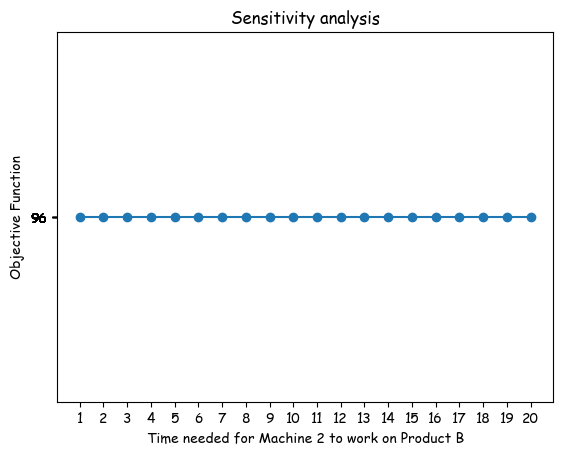

In [12]:
xticks = range(1, 20+1)

time_params = get_time_params()

answers = []
for i in xticks:
    time_params[(2,2)] = i
    Z = solve_gurobipy(time_params)
    answers.append(Z)

plot_lists(answers, xlabel="Time needed for Machine 2 to work on Product B", xticks=xticks, yticks=answers)

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
 زمان لازم برای ماشین کاری روی محصول A توسط ماشین 4
</div>

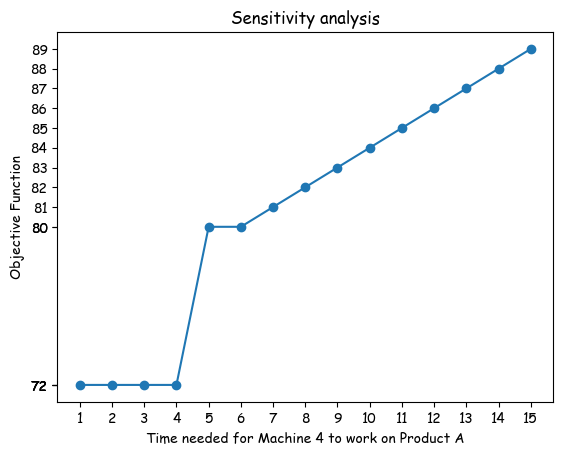

In [13]:
xticks = range(1,15+1)

time_params = get_time_params()

answers = []
for i in xticks:
    time_params[(4,1)] = i
    Z = solve_gurobipy(time_params)
    answers.append(Z)

plot_lists(answers, xlabel="Time needed for Machine 4 to work on Product A", xticks=xticks, yticks=answers)

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
 زمان لازم برای ماشین کاری روی محصول C توسط ماشین 5
</div>

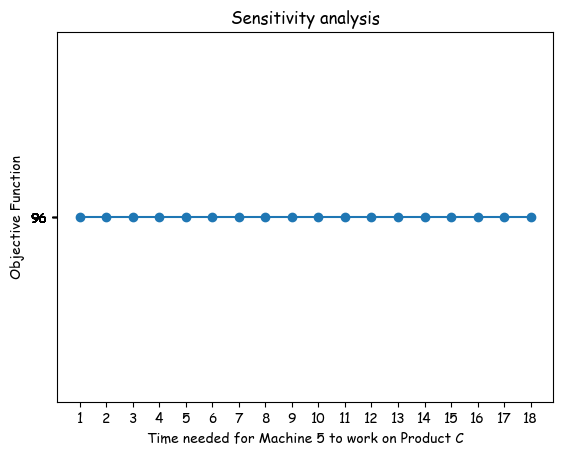

In [14]:
xticks = range(1, 18+1)

time_params = get_time_params()

answers = []
for i in xticks:
    time_params[(5,3)] = i
    Z = solve_gurobipy(time_params)
    answers.append(Z)

plot_lists(answers, xlabel="Time needed for Machine 5 to work on Product C", xticks=xticks, yticks=answers)

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
حداکثر زمان مجاز برای تکمیل محصول A
</div>

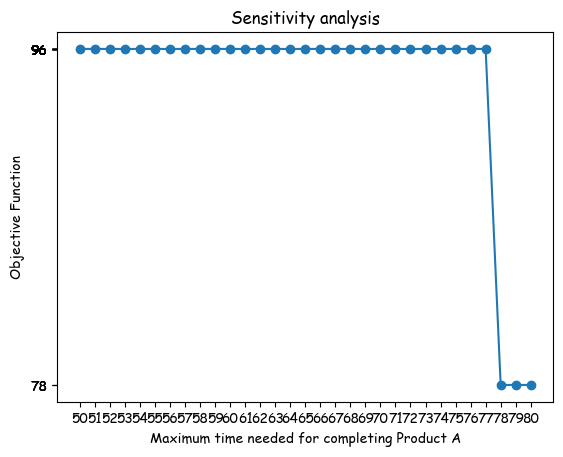

In [15]:
xticks = range(50, 80+1)

time_params = get_time_params()

answers = []
for k in xticks:
    Z = solve_gurobipy(time_params,A_finish_time=k)
    answers.append(Z)

plot_lists(answers, xlabel="Maximum time needed for completing Product A", xticks=xticks, yticks=answers)

<div style="font-family: Vazirmatn; font-size:24px; direction: rtl; display: flex; align-items:center; justify-content:center; align-text:center; background-color: #4c6ef5; padding: 10px 20px;border: 1px solid black; border-radius: 5px">
 حداقل زمان لازم برای انجام دو ماشین کاری متوالی روی ماشین 2
</div>

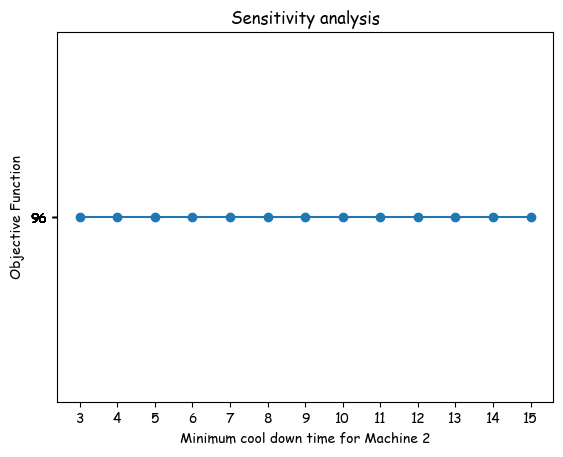

In [16]:
xticks = range(3, 15+1)
time_params = get_time_params()
machines_cool_down_times = {1:4, 2:10, 3:5, 4:20, 5:0}

answers = []
for k in xticks:
    machines_cool_down_times[2] = k
    Z = solve_gurobipy(time_params, machines_cool_down_times=machines_cool_down_times)
    answers.append(Z)

plot_lists(answers, xlabel="Minimum cool down time for Machine 2", xticks=xticks, yticks=answers)